In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Visulaize Optimization Process

### Build Model

In [2]:
def build_model(print_summary=False):
    '''
    Build model
    Args:
        print_summary: bool, whether or not to print model summary, default: False
    Returns:
        model: keras model
    '''
    model = Sequential()

    model.add(Flatten(input_shape=(28, 28), name="input"))
    model.add(Dense(16, use_bias=False, activation="relu", name="h1"))
    model.add(Dense(16, use_bias=False, activation="relu", name="h2"))
    model.add(Dense(10, use_bias=False, activation="softmax", name="output"))

    if print_summary:
        model.summary()

    return model

In [3]:
optimizer = Adam()
models = []
for i in range(8):
    m = build_model()
    if i == 0:
        m.summary()
    m.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    models.append(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
h1 (Dense)                   (None, 16)                12544     
_________________________________________________________________
h2 (Dense)                   (None, 16)                256       
_________________________________________________________________
output (Dense)               (None, 10)                160       
Total params: 12,960
Trainable params: 12,960
Non-trainable params: 0
_________________________________________________________________


### Data Preprocessing

In [4]:
# Load Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize
x_train = x_train / 255
x_test = x_test / 255
# Get One-Hot Labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

### Train Model

In [5]:
def get_batch(x, y, batch_size):
    '''
    Input whole data, output a batch data generator
    Args:
        x: ndarray, whole data featurs
        y: ndarray, whole data labels
        batch_size: int, size of batch
    Yields:
        batch: ndarray, batch_size of data features and labels
    '''
    num_batch = x.shape[0] // batch_size
    if x.shape[0] % batch_size != 0:
        num_batch += 1
    
    for i in range(num_batch):
        # get batch data
        if i != num_batch:
            batch_x = x[i*batch_size:(i+1)*batch_size]
            batch_y = y[i*batch_size:(i+1)*batch_size]
        else:    # last batch
            batch_x = x[i*batch_size:]
            batch_y = y[i*batch_size:]
        yield batch_x, batch_y

In [6]:
# Hyperparameters
EPOCHS = 30
BATCH_SIZE = 256

In [7]:
def train_model(training, model, testing=None, epochs=30, batch_size=256):
    '''
    Train model
    Args:
        training: tuple(of ndarray), training x and y
        model: keras model, model to be trained
        testing: tuple(of ndarray), testing x and y
        epochs: int, number of training epochs, default: 30
        batch_size: int, size of batch, default: 256
    Returns:
        history: dict, store training loss/accuracy and validation loss/accuracy during training process
        weights: ndarray, store weights of each layer in the model every 3 epochs
    '''
    x_train, y_train = training
    history = dict()
    history["loss"] = []
    history["acc"] = []
    if testing is not None:
        x_test, y_test = testing
        history["val_loss"] = []
        history["val_acc"] = []
    flag = True   # Store weights for the first time
    for e in range(epochs):
        # Shuffle
        idx = np.random.permutation(x_train.shape[0])
        # Train batch
        for b_x, b_y in get_batch(x_train[idx], y_train[idx], batch_size):
            loss, acc = model.train_on_batch(b_x, b_y)

        loss, acc = model.evaluate(x_train, y_train, verbose=0)
        history["loss"].append(loss)
        history["acc"].append(acc)

        if testing is not None:
            loss, acc = model.evaluate(x_test, y_test, verbose=0)
            history["val_loss"].append(loss)
            history["val_acc"].append(acc)

        print("Epoch %d/%d\tloss: %.4f\tacc: %.2f%%" % (e+1, EPOCHS, loss, acc*100))

        # Get weights
        if e % 3 == 0:
            # WARNING!!! This part is hard-coded cause I'm too lazy!!!
            # (Use for loop to get weights of different layers will be better)
            # l0 = model0.layers[0].get_weights()[0].flatten() <-- First layer is Flatten (no parameters)
            l1 = model.layers[1].get_weights()[0].flatten()
            l2 = model.layers[2].get_weights()[0].flatten()
            l3 = model.layers[3].get_weights()[0].flatten()
            if flag:
                weights = np.concatenate((l1, l2, l3))
                flag = False
            else:
                weights = np.vstack((weights, np.concatenate((l1, l2, l3))))
    return history, weights

In [8]:
history = []
weights = []
for i in range(8):
    print("=== Training Model %d ===" % i)
    h, w = train_model((x_train, y_train), models[i])
    history.append(h)
    weights.append(w)

=== Training Model 0 ===
Epoch 1/30	loss: 0.3803	acc: 89.55%
Epoch 2/30	loss: 0.2887	acc: 91.92%
Epoch 3/30	loss: 0.2433	acc: 93.03%
Epoch 4/30	loss: 0.2191	acc: 93.77%
Epoch 5/30	loss: 0.2022	acc: 94.31%
Epoch 6/30	loss: 0.1929	acc: 94.52%
Epoch 7/30	loss: 0.1808	acc: 94.86%
Epoch 8/30	loss: 0.1715	acc: 95.19%
Epoch 9/30	loss: 0.1668	acc: 95.25%
Epoch 10/30	loss: 0.1605	acc: 95.45%
Epoch 11/30	loss: 0.1503	acc: 95.75%
Epoch 12/30	loss: 0.1453	acc: 95.89%
Epoch 13/30	loss: 0.1407	acc: 96.03%
Epoch 14/30	loss: 0.1376	acc: 96.14%
Epoch 15/30	loss: 0.1359	acc: 96.17%
Epoch 16/30	loss: 0.1304	acc: 96.25%
Epoch 17/30	loss: 0.1255	acc: 96.43%
Epoch 18/30	loss: 0.1238	acc: 96.48%
Epoch 19/30	loss: 0.1205	acc: 96.58%
Epoch 20/30	loss: 0.1200	acc: 96.56%
Epoch 21/30	loss: 0.1203	acc: 96.45%
Epoch 22/30	loss: 0.1151	acc: 96.66%
Epoch 23/30	loss: 0.1126	acc: 96.72%
Epoch 24/30	loss: 0.1140	acc: 96.64%
Epoch 25/30	loss: 0.1103	acc: 96.85%
Epoch 26/30	loss: 0.1075	acc: 96.89%
Epoch 27/30	loss: 0.10

Epoch 9/30	loss: 0.1400	acc: 96.02%
Epoch 10/30	loss: 0.1367	acc: 96.10%
Epoch 11/30	loss: 0.1348	acc: 96.18%
Epoch 12/30	loss: 0.1349	acc: 96.20%
Epoch 13/30	loss: 0.1293	acc: 96.26%
Epoch 14/30	loss: 0.1264	acc: 96.33%
Epoch 15/30	loss: 0.1232	acc: 96.48%
Epoch 16/30	loss: 0.1196	acc: 96.57%
Epoch 17/30	loss: 0.1182	acc: 96.59%
Epoch 18/30	loss: 0.1147	acc: 96.73%
Epoch 19/30	loss: 0.1150	acc: 96.58%
Epoch 20/30	loss: 0.1146	acc: 96.66%
Epoch 21/30	loss: 0.1090	acc: 96.85%
Epoch 22/30	loss: 0.1084	acc: 96.85%
Epoch 23/30	loss: 0.1045	acc: 96.99%
Epoch 24/30	loss: 0.1064	acc: 96.91%
Epoch 25/30	loss: 0.1027	acc: 97.00%
Epoch 26/30	loss: 0.1035	acc: 97.00%
Epoch 27/30	loss: 0.1062	acc: 96.82%
Epoch 28/30	loss: 0.0997	acc: 97.04%
Epoch 29/30	loss: 0.1006	acc: 97.02%
Epoch 30/30	loss: 0.0973	acc: 97.13%


### Plot Learning Curves

In [8]:
def plot_learning_curve(history):
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(1-np.array(history["acc"]), label="Training Error Rate")
#     plt.plot(history["val_loss"], label="Testing Loss")
#     plt.plot(1-np.array(history["val_acc"]), label="Testing Error Rate")
    plt.legend()
    plt.title("Learning Curve")
    plt.show()

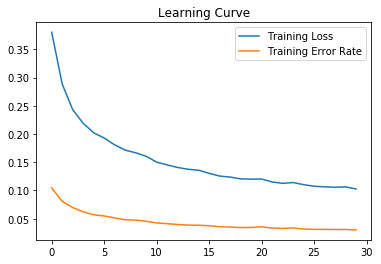

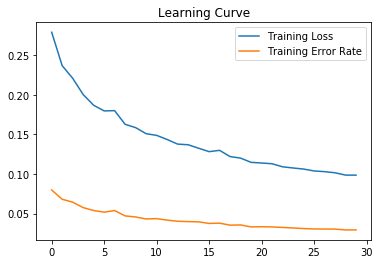

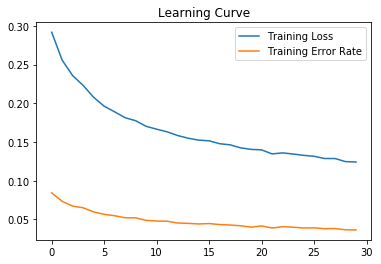

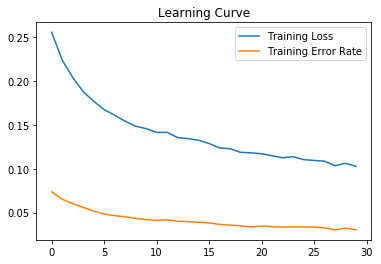

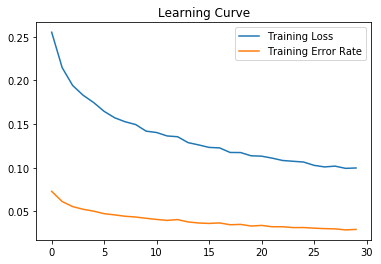

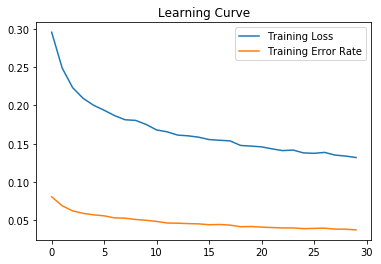

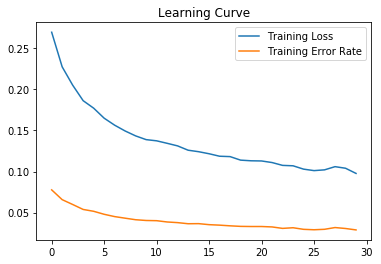

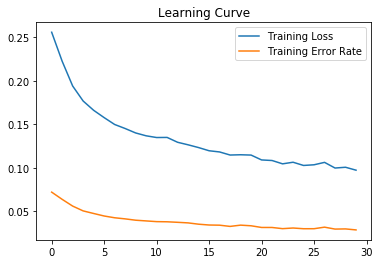

In [9]:
for i in range(8):
    plot_learning_curve(history[i])

### Apply PCA

In [10]:
# Concatenate weights of all events
#weights = np.concatenate((weights0, weights1, weights2, weights3, weights4, weights5, weights6, weights7))
whole_w = []
for w in weights:
    whole_w.append(w)
whole_w = np.concatenate((whole_w))

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Get layer 1 weights
l1_w = pca.fit_transform(whole_w[:, :12544])
# Get whole model weights
whole_w = pca.fit_transform(whole_w)

### Plot weights

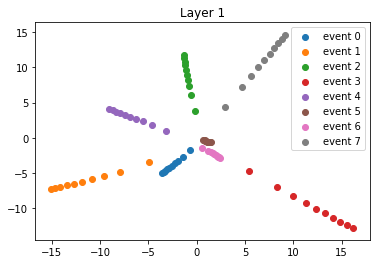

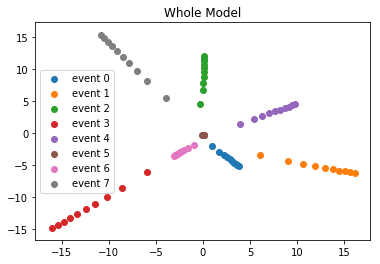

In [12]:
for i in range(8):
    l1_x = l1_w[i*(EPOCHS//3):(i+1)*(EPOCHS//3), 0]
    l1_y = l1_w[i*(EPOCHS//3):(i+1)*(EPOCHS//3), 1]
    label = "event %d" % i
    plt.scatter(l1_x, l1_y, label=label)
    plt.legend()
    plt.title("Layer 1")
plt.show()

for i in range(8):
    x = whole_w[i*(EPOCHS//3):(i+1)*(EPOCHS//3), 0]
    y = whole_w[i*(EPOCHS//3):(i+1)*(EPOCHS//3), 1]
    label = "event %d" % i
    plt.scatter(x, y, label=label)
    plt.legend()
    plt.title("Whole Model")
plt.show()

## Observe Gradient Norm During Training

### Build Model

In [13]:
model2 = build_model()

In [14]:
model2.compile(optimizer="adam", loss="categorical_crossentropy")

### Get Gradient Function

In [15]:
def get_gradients(model):
    """
    Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    optimizer = model.optimizer

    return optimizer.get_gradients(model.total_loss, weights)

### Train Model
*MNIST case only*

In [16]:
# Train model
gradients = []
losses = []
for e in range(5):
        # Shuffle
        idx = np.random.permutation(x_train.shape[0])
        counter = 0
        # Train batch
        for b_x, b_y in get_batch(x_train[idx], y_train[idx], 512):
            counter += 1
            # WARNING! This part is not appropriate (very time-consuming)
            # When you run train_on_batch(), you actually already get_gradients() and update parameters once
            loss = model2.train_on_batch(b_x, b_y)
            weights = model2.weights # weight tensors
            gradient = model2.optimizer.get_gradients(model2.total_loss, weights) # gradient tensors
            input_tensors = [
                model2.inputs[0], # input data
                model2.sample_weights[0], # sample weights
                model2.targets[0], # labels
                K.learning_phase(), # train or test mode
            ]
            get_gradients = K.function(inputs=input_tensors, outputs=gradient)

            inputs = [
                b_x, # X input data
                np.ones((b_x.shape[0],)), # sample weights
                b_y, # y labels
                0 # learning phase in TEST mode
            ]
            g = get_gradients(inputs)
#             loss = model2.evaluate(b_x, b_y, verbose=0)
            losses.append(loss)
            # Apply 2-norm
            g_0 = np.sum(g[0]**2)
            g_1 = np.sum(g[1]**2)
            g_2 = np.sum(g[2]**2)
            g_all = np.sqrt(g_0+g_1+g_2)
            gradients.append(g_all)
            print("Epoch %d/5\tBatch %d/%d\tloss: %.4f\tgradient: %.4f" % (e+1, counter, x_train.shape[0]//512+1, loss, g_all))

Epoch 1/5	Batch 1/118	loss: 2.3152	gradient: 0.4511
Epoch 1/5	Batch 2/118	loss: 2.3004	gradient: 0.4428
Epoch 1/5	Batch 3/118	loss: 2.2671	gradient: 0.4593
Epoch 1/5	Batch 4/118	loss: 2.2432	gradient: 0.4433
Epoch 1/5	Batch 5/118	loss: 2.2073	gradient: 0.4690
Epoch 1/5	Batch 6/118	loss: 2.1962	gradient: 0.4498
Epoch 1/5	Batch 7/118	loss: 2.1931	gradient: 0.4467
Epoch 1/5	Batch 8/118	loss: 2.1693	gradient: 0.4565
Epoch 1/5	Batch 9/118	loss: 2.1689	gradient: 0.4879
Epoch 1/5	Batch 10/118	loss: 2.1053	gradient: 0.5548
Epoch 1/5	Batch 11/118	loss: 2.1213	gradient: 0.5276
Epoch 1/5	Batch 12/118	loss: 2.0958	gradient: 0.5323
Epoch 1/5	Batch 13/118	loss: 2.0916	gradient: 0.5504
Epoch 1/5	Batch 14/118	loss: 2.0369	gradient: 0.6348
Epoch 1/5	Batch 15/118	loss: 2.0163	gradient: 0.5879
Epoch 1/5	Batch 16/118	loss: 2.0276	gradient: 0.5765
Epoch 1/5	Batch 17/118	loss: 1.9811	gradient: 0.5634
Epoch 1/5	Batch 18/118	loss: 1.9685	gradient: 0.5616
Epoch 1/5	Batch 19/118	loss: 1.9480	gradient: 0.6059
Ep

Epoch 2/5	Batch 38/118	loss: 0.4568	gradient: 0.4503
Epoch 2/5	Batch 39/118	loss: 0.4189	gradient: 0.5449
Epoch 2/5	Batch 40/118	loss: 0.3763	gradient: 0.3911
Epoch 2/5	Batch 41/118	loss: 0.4139	gradient: 0.3862
Epoch 2/5	Batch 42/118	loss: 0.3855	gradient: 0.3404
Epoch 2/5	Batch 43/118	loss: 0.4144	gradient: 0.4023
Epoch 2/5	Batch 44/118	loss: 0.4186	gradient: 0.4224
Epoch 2/5	Batch 45/118	loss: 0.3970	gradient: 0.4487
Epoch 2/5	Batch 46/118	loss: 0.3828	gradient: 0.3804
Epoch 2/5	Batch 47/118	loss: 0.4321	gradient: 0.5420
Epoch 2/5	Batch 48/118	loss: 0.3939	gradient: 0.3470
Epoch 2/5	Batch 49/118	loss: 0.4269	gradient: 0.4440
Epoch 2/5	Batch 50/118	loss: 0.5003	gradient: 0.6807
Epoch 2/5	Batch 51/118	loss: 0.3992	gradient: 0.4896
Epoch 2/5	Batch 52/118	loss: 0.3807	gradient: 0.4220
Epoch 2/5	Batch 53/118	loss: 0.3979	gradient: 0.4867
Epoch 2/5	Batch 54/118	loss: 0.4348	gradient: 0.5862
Epoch 2/5	Batch 55/118	loss: 0.4242	gradient: 0.4951
Epoch 2/5	Batch 56/118	loss: 0.4249	gradient: 

Epoch 3/5	Batch 75/118	loss: 0.3205	gradient: 0.3454
Epoch 3/5	Batch 76/118	loss: 0.3605	gradient: 0.5363
Epoch 3/5	Batch 77/118	loss: 0.2238	gradient: 0.3662
Epoch 3/5	Batch 78/118	loss: 0.2708	gradient: 0.5497
Epoch 3/5	Batch 79/118	loss: 0.2912	gradient: 0.4533
Epoch 3/5	Batch 80/118	loss: 0.3765	gradient: 0.6605
Epoch 3/5	Batch 81/118	loss: 0.2920	gradient: 0.5493
Epoch 3/5	Batch 82/118	loss: 0.3384	gradient: 0.4590
Epoch 3/5	Batch 83/118	loss: 0.2866	gradient: 0.3307
Epoch 3/5	Batch 84/118	loss: 0.2864	gradient: 0.4574
Epoch 3/5	Batch 85/118	loss: 0.2740	gradient: 0.4264
Epoch 3/5	Batch 86/118	loss: 0.3129	gradient: 0.4147
Epoch 3/5	Batch 87/118	loss: 0.2887	gradient: 0.3750
Epoch 3/5	Batch 88/118	loss: 0.3193	gradient: 0.6252
Epoch 3/5	Batch 89/118	loss: 0.4154	gradient: 0.5869
Epoch 3/5	Batch 90/118	loss: 0.2709	gradient: 0.4946
Epoch 3/5	Batch 91/118	loss: 0.3313	gradient: 0.5808
Epoch 3/5	Batch 92/118	loss: 0.3315	gradient: 0.4569
Epoch 3/5	Batch 93/118	loss: 0.3134	gradient: 

Epoch 4/5	Batch 112/118	loss: 0.3327	gradient: 0.4991
Epoch 4/5	Batch 113/118	loss: 0.2738	gradient: 0.7148
Epoch 4/5	Batch 114/118	loss: 0.2859	gradient: 0.3521
Epoch 4/5	Batch 115/118	loss: 0.2814	gradient: 0.3943
Epoch 4/5	Batch 116/118	loss: 0.2892	gradient: 0.4227
Epoch 4/5	Batch 117/118	loss: 0.3307	gradient: 0.5785
Epoch 4/5	Batch 118/118	loss: 0.2580	gradient: 1.1216
Epoch 5/5	Batch 1/118	loss: 0.2219	gradient: 0.5911
Epoch 5/5	Batch 2/118	loss: 0.2939	gradient: 0.7461
Epoch 5/5	Batch 3/118	loss: 0.2265	gradient: 0.5217
Epoch 5/5	Batch 4/118	loss: 0.2958	gradient: 0.7179
Epoch 5/5	Batch 5/118	loss: 0.2690	gradient: 0.6608
Epoch 5/5	Batch 6/118	loss: 0.2616	gradient: 0.5400
Epoch 5/5	Batch 7/118	loss: 0.2778	gradient: 0.5857
Epoch 5/5	Batch 8/118	loss: 0.2446	gradient: 0.6010
Epoch 5/5	Batch 9/118	loss: 0.2638	gradient: 0.5598
Epoch 5/5	Batch 10/118	loss: 0.2601	gradient: 0.3960
Epoch 5/5	Batch 11/118	loss: 0.2897	gradient: 0.4837
Epoch 5/5	Batch 12/118	loss: 0.2691	gradient: 0.

### Plot Result

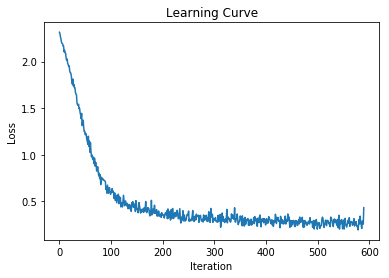

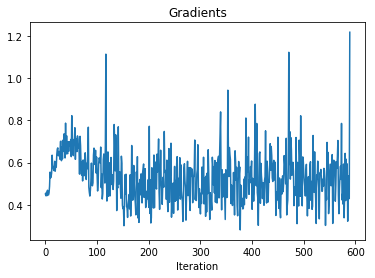

In [17]:
# Plot Loss
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()
# Plot Gradients
plt.plot(gradients)
plt.xlabel("Iteration")
plt.title("Gradients")
plt.show()

## What Happened When Gradient is Almost Zero

In [ ]:
# TODO
# This part is canceled